<div style="background-color: #f0f8ff; padding: 10px;">
   <font color="black" face="verdana" size="3">

**Optimization Group 11 Project 2**

</font>
</div>

<div style="background-color: #f0f8ff; padding: 10px;">
   <font color="black" face="verdana" size="3">

**Group Members:**
- Abhijit Anil 
- Shrinidhi Krpete Thimmegowda
- Meghavi Singhaniya 
- Sai Lakshmi 

**Problem Description**

Equity money management strategies are largely classified as either ‘active’ or ‘passive’. The most common passive strategy is that of “indexing” where the goal is to choose a portfolio that mirrors the movements of the broad market population or a market index. Such a portfolio is called an index fund. For example, the QQQ Index fund tracks the NASDAQ-100 index.

Constructing an index fund that tracks a specific broad market index could be done by simply purchasing all n stocks in the index, with the same weights as in the index. However, this approach is impractical (many small positions) and expensive (rebalancing costs may frequently be incurred, price response to trading). An index fund with m stocks, where m is substantially smaller than the size of the target population, n, seems desirable.
In this project, we will create an Index fund with m stocks to track the NASDAQ-100 index. We will do this in multiple steps. First, we will formulate an integer program that picks exactly m out of n stocks for our portfolio. This integer program will take as input a ‘similarity matrix’, which we will call 𝜌. The individual elements of this matrix, 𝜌𝑖𝑗, represent similarity between stock i and j. An example of this is the correlation between the returns of stocks i and j. But one could choose other similarity metrics 𝜌𝑖𝑗.

Next, you will solve a linear program to decide how many of each chosen stock to buy for your portfolio and finally evaluate how well your index fund does as compared to the NASDAQ-100 index, out of sample. You will examine the performance for several values of m.

</font>
</div>

In [194]:
import numpy as np
import gurobipy as gp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

<div style="background-color: #f0f8ff; padding: 10px;">
   <font color="black" face="verdana" size="3">

Two csv files are included with this assignment. One of those files contains daily prices of the index as well as the component stocks of the NASDAQ-100 in 2019. The first column is the date, the second column is the index price (NDX), and columns 3-102 are the prices of the component stocks. The second file is the same, except it’s 2020 prices. (We are using pre- and post- shutdown data to see if anything fishy happens!) There were actually 103 stocks in the NASDAQ-100 in 2020, but 3 of them are new stocks that don’t have data for all of 2019, so I just removed them. You’re going to use the 2019 file for all your portfolio construction tasks and then analyze the performance on the 2020 file; that is, how well does your portfolio, constructed with 2019 data, track the index in 2020? When we grade your assignment, we will use different csv files with potentially a different number of days and a different index with a different number of component stocks.

</font>
</div>


In [195]:
# Load data for the year 2019 from 'stocks2019.csv' into a DataFrame called df_2019
df_2019 = pd.read_csv('stocks2019.csv')
df_2019_only_stocks = df_2019.set_index(df_2019.columns[0])

# Load data for the year 2020 from 'stocks2020.csv' into a DataFrame called df_2020
df_2020 = pd.read_csv('stocks2020.csv')
df_2020_only_stocks = df_2020.set_index(df_2020.columns[0])

<div style="background-color: #f0f8ff; padding: 10px;">
   <font color="black" face="verdana" size="3">

 You will need to calculate the returns of the stocks in the 2019 file to calculate the correlation matrix for stock selection and weight construction, and you will need the returns of the index for weight construction. You will also need the daily returns in 2020 for both the index and the stocks to evaluate the performance of your portfolio in 2020. Use the correlation matrix of returns as 𝜌.

</font>
</div>

<div style="background-color: #f0f8ff; padding: 10px;">
   <font color="black" face="verdana" size="3">
   
### **Function Definitions**

</font>
</div>


In [196]:
def validate(stocks_2019, stocks2020):

    # Validation 1: Minimum number of stocks should always be greater than 5
    if min(stocks_2019, stocks2020) < 5:
        raise SystemExit('The number of stocks in either 2019 or 2020 is less than 5. Need more stocks.')

    # Validation 2: 2019 and 2020 should have the same number of stocks for the performance of weights to be compared
    elif stocks_2019 != stocks2020:
        raise SystemExit('Please make sure the stock count is equal. 2020 and 2019 stock counts are mismatched')


<div style="background-color: #f0f8ff; padding: 10px;">
   <font color="black" face="verdana" size="3">
   
**Function for Stock Selection**

$$ \underset{x,y}max \sum_{i=1}^n \sum_{i=1}^n \rho_{ij}x_{ij} $$
$$ s.t. \sum_{j=1}^n y_j = m $$
$$ \sum_{j=1}^n x_{ij} = 1 \; for \; i = 1,2,...,n $$
$$ x_{ij} \leq y_j \; for \; i,j = 1,2,...,n $$
$$ x_{ij} > 0, y_j \in \{0,1\} $$

</font>
</div>


In [197]:
def select_stocks(num_stocks,p,num_of_stocks_to_select):
    Model = gp.Model()
    y = Model.addMVar(num_stocks, vtype = 'B')
    x = Model.addMVar((num_stocks,num_stocks), vtype = 'B')
    ModCon = Model.addConstr(gp.quicksum(y[i]for i in range (num_stocks)) == num_of_stocks_to_select)
    ModCon_2 = Model.addConstrs(gp.quicksum(x[i][j]for j in range (num_stocks)) == 1 for i in range (num_stocks))
    ModCon_3 = Model.addConstrs(x[i][j] <= y[j] for j in range (num_stocks) for i in range(num_stocks))

    objective = gp.quicksum(x[i][j] * p.values[i, j] for i in range(100) for j in range(100))
    Model.setObjective(objective, gp.GRB.MAXIMIZE)

    Model.Params.OutputFlag = 0 # tell gurobi to shut up!!
    Model.optimize()

    # Access the objective value
    objective_value = Model.objVal

    indices_with_ones = np.where(y.X == 1)[0]
    print('The '+ str(num_of_stocks_to_select) +' selected stocks are:')
    i=1
    for index in indices_with_ones:
        column_name = p.columns[index]
        print(f"Stock {i}: {column_name}")
        i = i+1

    print('\n')
    return y.x

<div style="background-color: #f0f8ff; padding: 10px;">
   <font color="black" face="verdana" size="3">
   
**Function for Calculating Portfolio Weights**

$$ \underset{w}min \sum_{t=1}^T | q_t - \sum_{i=1}^m w_i r_{it}| $$
$$ s.t. \sum_{i=1}^m w_i = 1 $$
$$ q_t - \sum_{i=1}^m w_i r_{it} \leq d_t \; for \; t = 1,2,...,T $$
$$ - q_t + \sum_{i=1}^m w_i r_{it} \leq d_t \; for \; t = 1,2,...,T $$
$$ w_i \geq 0 $$

</font>
</div>



In [198]:
def weight_calculation(stock_selection, returns,num_stocks, num_time_periods,num_of_stocks_to_select):
    Model_2 = gp.Model()
    w = Model_2.addMVar(num_stocks,vtype=gp.GRB.CONTINUOUS)
    ModCon_1_2 = Model_2.addConstr(gp.quicksum(w[i]for i in range (num_stocks)) == 1)
    ModCon_2 = Model_2.addConstrs((w[i] <= 100000 * stock_selection[i] for i in range (num_stocks)))
    # for i in range (num_stocks):
    #     if stock_selection[i] != 0:
    #         ModCon_3 = Model_2.addConstr(w[i] >0)
    a = Model_2.addMVar(num_time_periods)

    for i in range (num_time_periods):
        Model_2.addConstr(a[i] >= returns.values[i][0] - (gp.quicksum(w[j]*returns.values[i][j+1] for j in range (num_stocks))))

    for i in range (num_time_periods):
        Model_2.addConstr(a[i] >= -(returns.values[i][0] - (gp.quicksum(w[j]*returns.values[i][j+1] for j in range (num_stocks)))))


    objective = gp.quicksum(a[i] for i in range(num_time_periods))
    Model_2.setObjective(objective, gp.GRB.MINIMIZE)

    Model_2.Params.OutputFlag = 0 # tell gurobi to shut up!!
    # Optimize the model
    Model_2.optimize()

    indices_with_ones = np.where(w.X != 0)[0]

    print('For '+str(num_of_stocks_to_select)+' stocks')
    for index in indices_with_ones:
        column_name = ret_2.columns[index+1]
        print(f"Weight of stock {column_name}: {w.x[index]}")

    print('\n')

    weights_dict = {'Stock': [], 'Weight': []}
    for index in indices_with_ones:
        column_name = ret_2.columns[index + 1]
        weight = w.x[index]
        weights_dict['Stock'].append(column_name)
        weights_dict['Weight'].append(weight)

    weights_df = pd.DataFrame(weights_dict)

    return w.x,weights_df

<div style="background-color: #f0f8ff; padding: 10px;">
   <font color="black" face="verdana" size="3">
   
**Function for index return error calculation**

</font>
</div>



In [199]:
def index_return_calculation(weights,returns,num_rows,num_stocks,m):
    diff = 0
    returns_dict = {}
    returns_dict[str(m)] = []  # Initialize the value for 'key1' as an empty list

    for i in range (num_rows):
        sum_1 = 0
        for j in range(num_stocks):
            sum_1 = sum_1 + (weights[j]*returns.values[i][j+1])

        diff = diff + abs(returns.values[i][0] - sum_1)
        returns_dict[str(m)].append(abs(returns.values[i][0] - sum_1))

    returns_dict[str(m)].append(diff)
    # print(diff)

    return returns_dict

<div style="background-color: #f0f8ff; padding: 10px;">
   <font color="black" face="verdana" size="3">
   
**Function to calculate portfolio metrics**

</font>
</div>



In [200]:
def calculate_portfolio_metrics(weights_calculated, returns_data):
    # Extract the 'Stock' column from weights_calculated
    selected_stocks = weights_calculated['Stock']

    # Filter the columns of returns_data based on the selected stocks
    selected_returns = returns_data[selected_stocks]

    # Multiply the selected_returns by the corresponding weights
    portfolio_returns = selected_returns.mul(weights_calculated.set_index('Stock')['Weight'], axis=1)

    # Calculate the portfolio return for each date in the returns_data
    portfolio_returns['Portfolio_Return'] = portfolio_returns.sum(axis=1)

    # Calculate the tracking error for each date
    tracking_error = abs(portfolio_returns['Portfolio_Return'] - returns_data.iloc[:, 0])

    # Sum the tracking errors for all dates
    total_tracking_error = tracking_error.sum()

    return portfolio_returns, total_tracking_error


In [201]:
# Set the first column of the DataFrame df_2019 as the index
df_2019_returns = df_2019.set_index(df_2019.columns[0])

# Convert the DataFrame to daily returns
daily_returns = df_2019_returns.pct_change()

# Remove rows with NaN values
df_2019_returns = daily_returns.dropna()

# Calculate the correlation matrix between the component stocks
p = df_2019_returns.iloc[:, 1:].corr()

In [202]:
# Number of stocks (excluding 'NDX' and 'X' columns) in 2019
number_of_stocks = len(df_2019.columns[2:])  # Subtract 2 for 'NDX' and 'X'
number_of_stocks_2020 = len(df_2020.columns[2:])  # Subtract 2 for 'NDX' and 'X'

In [203]:
# Validate if there are sufficient stocks and if the stock counts are equal
vaildate_stocks = validate(number_of_stocks,number_of_stocks_2020)

# Number of time periods in 2019 (excluding the first row)
number_of_time_periods = len(df_2019) - 1

# Number of time periods in 2020 (excluding the first row)
number_of_time_periods_2020 = len(df_2020) - 1

# List of m values to consider, starting with 5 and incrementing by 10 up to the number of stocks
m_list = [10] + [i for i in range(20, number_of_stocks + 1, 10)]

# Display the list of m values
m_list

[10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

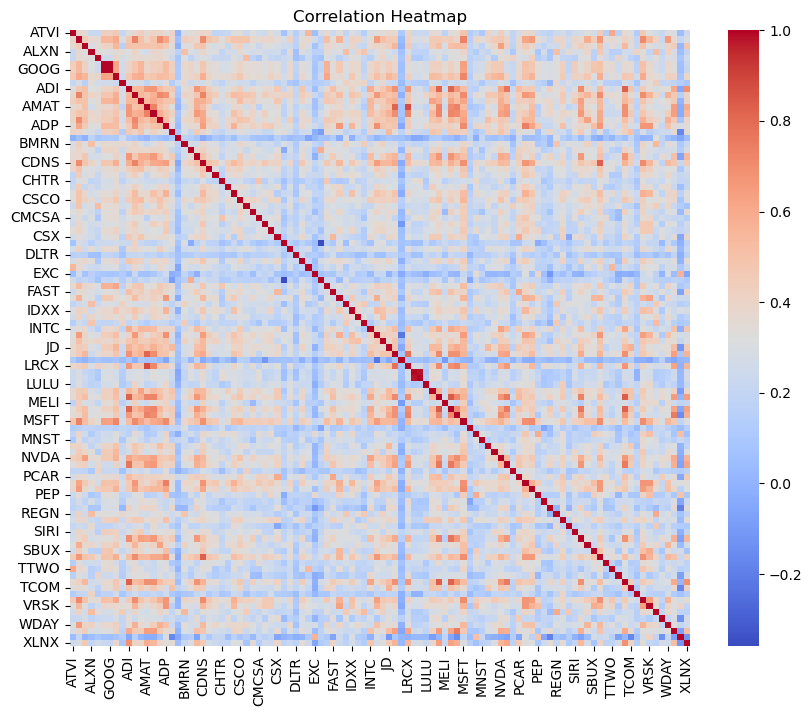

In [204]:
# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(p, annot=False, cmap='coolwarm')

# Set the plot title
plt.title("Correlation Heatmap")

# Show the plot
plt.show()

In [205]:
# Set the first column of the DataFrame df_2020 as the index
df_2020_returns = df_2020.set_index(df_2020.columns[0])

# Convert the DataFrame to daily returns
daily_returns_2 = df_2020_returns.pct_change()

# Remove rows with NaN values to ensure there are no null returns
df_2020_returns = daily_returns_2.dropna()

In [206]:
# Assign the DataFrame with daily returns for the year 2019 to 'ret'
ret = df_2019_returns

# Assign the DataFrame with daily returns for the year 2020 to 'ret_2'
ret_2 = df_2020_returns


<div style="background-color: #f0f8ff; padding: 10px;">
   <font color="black" face="verdana" size="3">
   
## EDA

### Average of each stocks and percentage change

</font>
</div>


In [207]:
# Calculate average daily returns for the year 2019
average_returns_2019 = df_2019_returns.mean()

# Calculate average daily returns for the year 2020
average_returns_2020 = df_2020_returns.mean()

# Create DataFrames from the average returns
df_average_returns_2019 = pd.DataFrame({'Average_Return_2019': average_returns_2019})
df_average_returns_2020 = pd.DataFrame({'Average_Return_2020': average_returns_2020})

# Concatenate the DataFrames
average_returns_combined = pd.concat([df_average_returns_2019, df_average_returns_2020], axis=1)

# Add a new column for the difference between 2020 and 2019
average_returns_combined['Difference'] = average_returns_combined['Average_Return_2020'] - average_returns_combined['Average_Return_2019']

# Add a new column for the percentage change
average_returns_combined['Percentage_Change'] = (average_returns_combined['Difference'] / average_returns_combined['Average_Return_2019']) * 100

# Display the combined DataFrame
average_returns_combined


,Average_Return_2019,Average_Return_2020,Difference,Percentage_Change
NDX,0.001311,0.001741,0.000430,32.763530
ATVI,0.001184,0.002102,0.000918,77.497254
ADBE,0.001633,0.002039,0.000405,24.812720
AMD,0.004097,0.003248,-0.000850,-20.735618
ALXN,0.000635,0.001926,0.001290,203.037107
...,...,...,...,...
WBA,-0.000302,-0.000980,-0.000679,225.083971
WDAY,0.000341,0.001914,0.001574,461.881980
WDC,0.002550,-0.000136,-0.002686,-105.317799
XEL,0.001236,0.000612,-0.000624,-50.470920


<div style="background-color: #f0f8ff; padding: 10px;">
   <font color="black" face="verdana" size="3">
   
### How many stocks had a negative pct change and how many had a positive pct change?

</font>
</div>


In [208]:
# Exclude the first row from the DataFrame since it show the percentage change for the index
filtered_returns = average_returns_combined.iloc[1:]

# Calculate the number of stocks with a negative percentage change
negative_changes = filtered_returns[filtered_returns['Percentage_Change'] < 0]

# Calculate the number of stocks with a positive percentage change
positive_changes = filtered_returns[filtered_returns['Percentage_Change'] > 0]

# Calculate the number of stocks with no percentage change
no_changes = filtered_returns[filtered_returns['Percentage_Change'] == 0]

# Get the counts for negative, positive, and no changes
num_negative_changes = len(negative_changes)
num_positive_changes = len(positive_changes)
num_no_changes = len(no_changes)

# Display the results
print("Number of stocks with a negative percentage change:", num_negative_changes)
print("Number of stocks with a positive percentage change:", num_positive_changes)
print("Number of stocks with no percentage change:", num_no_changes)


Number of stocks with a negative percentage change: 52
Number of stocks with a positive percentage change: 48
Number of stocks with no percentage change: 0


<div style="background-color: #f0f8ff; padding: 10px;">
   <font color="black" face="verdana" size="3">
   
### Graph to show the change in NDX

</font>
</div>


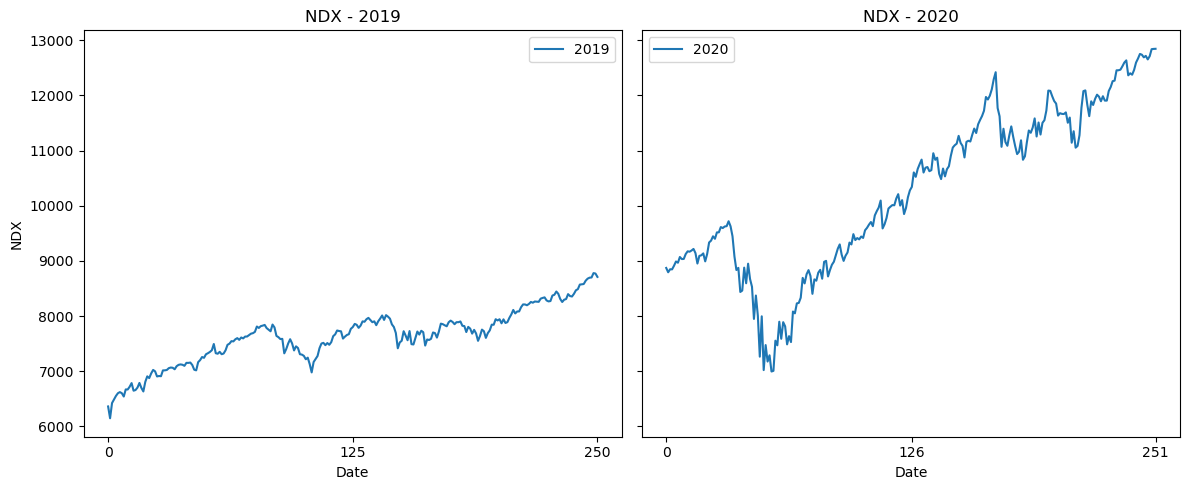

In [209]:
# Extract the 'NDX' column from both DataFrames
data_2019 = df_2019_only_stocks.iloc[:, 0]
data_2020 = df_2020_only_stocks.iloc[:, 0]

# Create a figure with two subplots side by side, sharing the y-axis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Plot for 2019 with x-axis from the DataFrame's index
x_2019 = df_2019.index
ax1.plot(x_2019, data_2019, label='2019')
ax1.set_title('NDX - 2019')
ax1.set_xlabel('Date')
ax1.set_ylabel('NDX')
ax1.legend()

# Plot for 2020 with x-axis from the DataFrame's index
x_2020 = df_2020.index
ax2.plot(x_2020, data_2020, label='2020')
ax2.set_title('NDX - 2020')
ax2.set_xlabel('Date')
ax2.legend()

# Set x-axis ticks to display only the first, middle, and last values
ax1.set_xticks([x_2019[0], x_2019[len(x_2019) // 2], x_2019[-1]])
ax2.set_xticks([x_2020[0], x_2020[len(x_2020) // 2], x_2020[-1]])

plt.tight_layout()
plt.show()


<div style="background-color: #f0f8ff; padding: 10px;">
   <font color="black" face="verdana" size="3">
   
### Highest increase and decrease in stock return

</font>
</div>


In [210]:
# Calculate the mean average returns for 2019 and 2020
mean_return_2019 = average_returns_combined['Average_Return_2019'].mean()
mean_return_2020 = average_returns_combined['Average_Return_2020'].mean()

# Calculate the percentage change in mean returns from 2019 to 2020
percentage_change = ((mean_return_2020 - mean_return_2019) / mean_return_2019) * 100

print(f"Mean Average Return in 2019: {mean_return_2019:.2}")
print(f"Mean Average Return in 2020: {mean_return_2020:.2}")
print(f"Percentage Change in Mean Returns (2019 to 2020): {percentage_change:.2}%")

Mean Average Return in 2019: 0.0014
Mean Average Return in 2020: 0.0017
Percentage Change in Mean Returns (2019 to 2020): 2.1e+01%


In [211]:
# Find the stock with the highest positive increase
max_increase_stock = average_returns_combined['Difference'].idxmax()

# Find the maximum positive increase
max_increase_value = average_returns_combined['Difference'].max()

# Find the stock with the highest percentage increase
max_percentage_increase_stock = average_returns_combined['Percentage_Change'].idxmax()

# Find the maximum percentage increase
max_percentage_increase_value = average_returns_combined['Percentage_Change'].max()

print(f"The stock with the highest percentage increase: {max_percentage_increase_stock}")
print(f"The highest percentage increase: {max_percentage_increase_value}%")

The stock with the highest percentage increase: CTSH
The highest percentage increase: 2165.6624232161794%


In [212]:
# Find the stock with the highest negative decrease
min_decrease_stock = average_returns_combined['Difference'].idxmin()

# Find the maximum negative decrease
min_decrease_value = average_returns_combined['Difference'].min()

# Find the stock with the highest negative percentage decrease
min_percentage_decrease_stock = average_returns_combined['Percentage_Change'].idxmin()

# Find the maximum negative percentage decrease
min_percentage_decrease_value = average_returns_combined['Percentage_Change'].min()

#print("The stock with the highest negative decrease:", min_decrease_stock)
#print("The highest negative decrease:", min_decrease_value)

print("The stock with the highest negative percentage decrease:", min_percentage_decrease_stock)
print(f"The highest negative percentage decrease: {min_percentage_decrease_value}%")

The stock with the highest negative percentage decrease: BIDU
The highest negative percentage decrease: -417.73621307210254%


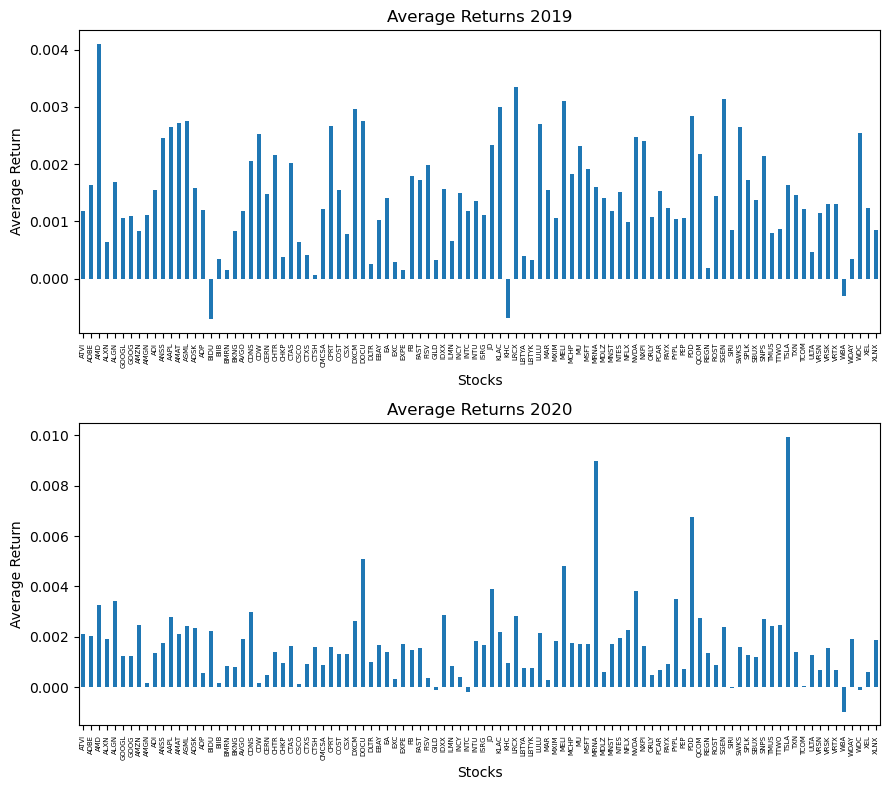

In [213]:
# Filter only the numeric columns for calculating returns
numeric_columns_2019 = df_2019.select_dtypes(include=[float])
numeric_columns_2020 = df_2020.select_dtypes(include=[float])

# Calculate daily returns for the numeric columns and remove the first row
daily_returns_2019 = numeric_columns_2019.pct_change().dropna()
daily_returns_2020 = numeric_columns_2020.pct_change().dropna()

# Calculate the average returns for each column
average_returns_2019 = daily_returns_2019.mean()
average_returns_2020 = daily_returns_2020.mean()

# Create a new figure
plt.figure(figsize=(9, 8))

# Plot for 2019 returns at the top
plt.subplot(2, 1, 1)
ax1 = average_returns_2019[1:].plot(kind='bar', title='Average Returns 2019')
plt.xlabel('Stocks')
plt.ylabel('Average Return')

# Plot for 2020 returns at the bottom
plt.subplot(2, 1, 2)
ax2 = average_returns_2020[1:].plot(kind='bar', title='Average Returns 2020')
plt.xlabel('Stocks')
plt.ylabel('Average Return')

# Reduce the x-axis label font size
ax1.tick_params(axis='x', labelrotation=90, labelsize=5)
ax2.tick_params(axis='x', labelrotation=90, labelsize=5)

plt.tight_layout()
plt.show()


In [214]:
#dfs to store indexes and weights calculated
column_names = df_2019.columns.tolist()

# Create an empty DataFrame with the same column names
selected_df = pd.DataFrame(columns=column_names[2:])
selected_df.insert(0, 'M', None)

weights_df = pd.DataFrame(columns=column_names[2:])
weights_df.insert(0, 'M', None)

# Assuming you have a DataFrame ret_2
new_index = ret_2.index.append(pd.Index(['Total']))

# Create an empty DataFrame with the new index
returns_df = pd.DataFrame(index=new_index)

<div style="background-color: #f0f8ff; padding: 10px;">
   <font color="black" face="verdana" size="3">
   
### 2

Start with m=5. Find the best 5 stocks to include in your portfolio and the weights of those 5 stocks, using the 2019 data. How well does this portfolio track the index in 2020? That is, calculate Σ|𝑞𝑡−Σ𝑤𝑖𝑟𝑖𝑡5𝑖=1|𝑇𝑡=1 using the 2020 data (except wi is from your 2019 solution…).

</font>
</div>


In [215]:
variance_data = []

selected_stocks = select_stocks(number_of_stocks,p,5)

new_row_df = pd.DataFrame([selected_stocks], columns=column_names[2:])

# Concatenate the original DataFrame and the new row DataFrame
selected_df = pd.concat([selected_df, new_row_df], ignore_index=True)
selected_df.at[len(selected_df)-1, 'M'] = 5


#Weight Calcuation
weights_calculated_m,weights_calculated = weight_calculation(selected_stocks, ret,number_of_stocks, number_of_time_periods, 5)

new_row_df = pd.DataFrame([weights_calculated_m], columns=column_names[2:])

# Concatenate the original DataFrame and the new row DataFrame
weights_df = pd.concat([weights_df, new_row_df], ignore_index=True)
weights_df.at[len(selected_df)-1, 'M'] = 5


values = index_return_calculation(weights_df.iloc[0,1:],ret_2,number_of_time_periods_2020,number_of_stocks,5)
returns_df = returns_df.assign(**values)

portfolio_returns_2020, tracking_error_2020 = calculate_portfolio_metrics(weights_calculated, ret_2)
portfolio_returns_2019, tracking_error_2019 = calculate_portfolio_metrics(weights_calculated, ret)  # Calculate 2019 variance

# Store the variance data for both 2020 and 2019
variance_data.append({'M': 5, 'Variance for 2020': tracking_error_2020, 'Variance for 2019': tracking_error_2019})

# Create a new DataFrame from the variance data
variance_df = pd.DataFrame(variance_data)


The 5 selected stocks are:
Stock 1: LBTYK
Stock 2: MXIM
Stock 3: MSFT
Stock 4: VRTX
Stock 5: XEL


For 5 stocks
Weight of stock LBTYK: 0.04886174835252491
Weight of stock MXIM: 0.21038806005665553
Weight of stock MSFT: 0.5803519807862964
Weight of stock VRTX: 0.07119021516911037
Weight of stock XEL: 0.08920799563541283




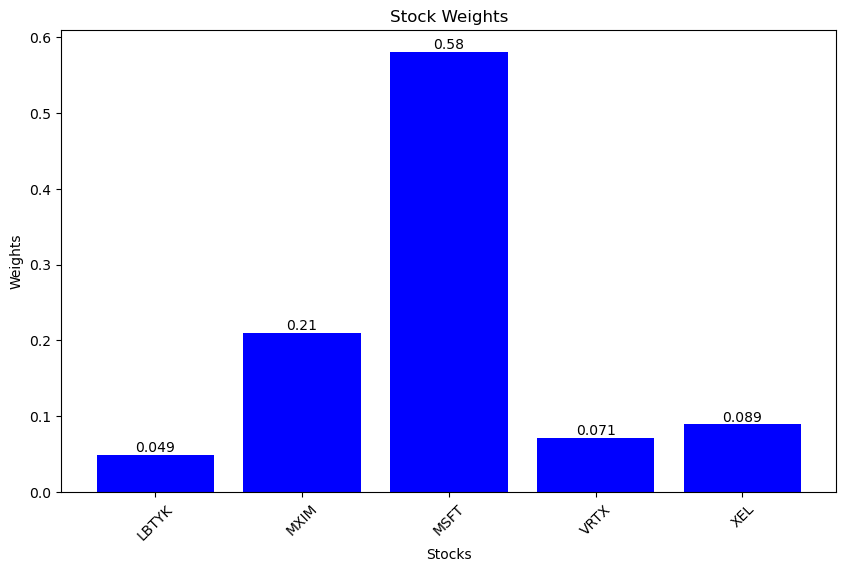

In [216]:
# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(weights_calculated['Stock'], weights_calculated['Weight'], color='blue')
plt.xlabel('Stocks')
plt.ylabel('Weights')
plt.title('Stock Weights')

# Add values on top of each bar
for index, row in weights_calculated.iterrows():  # Use weights_calculated here
    plt.text(index, row['Weight'], round(row['Weight'], 3), ha='center', va='bottom', fontsize=10)

# Show the plot
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

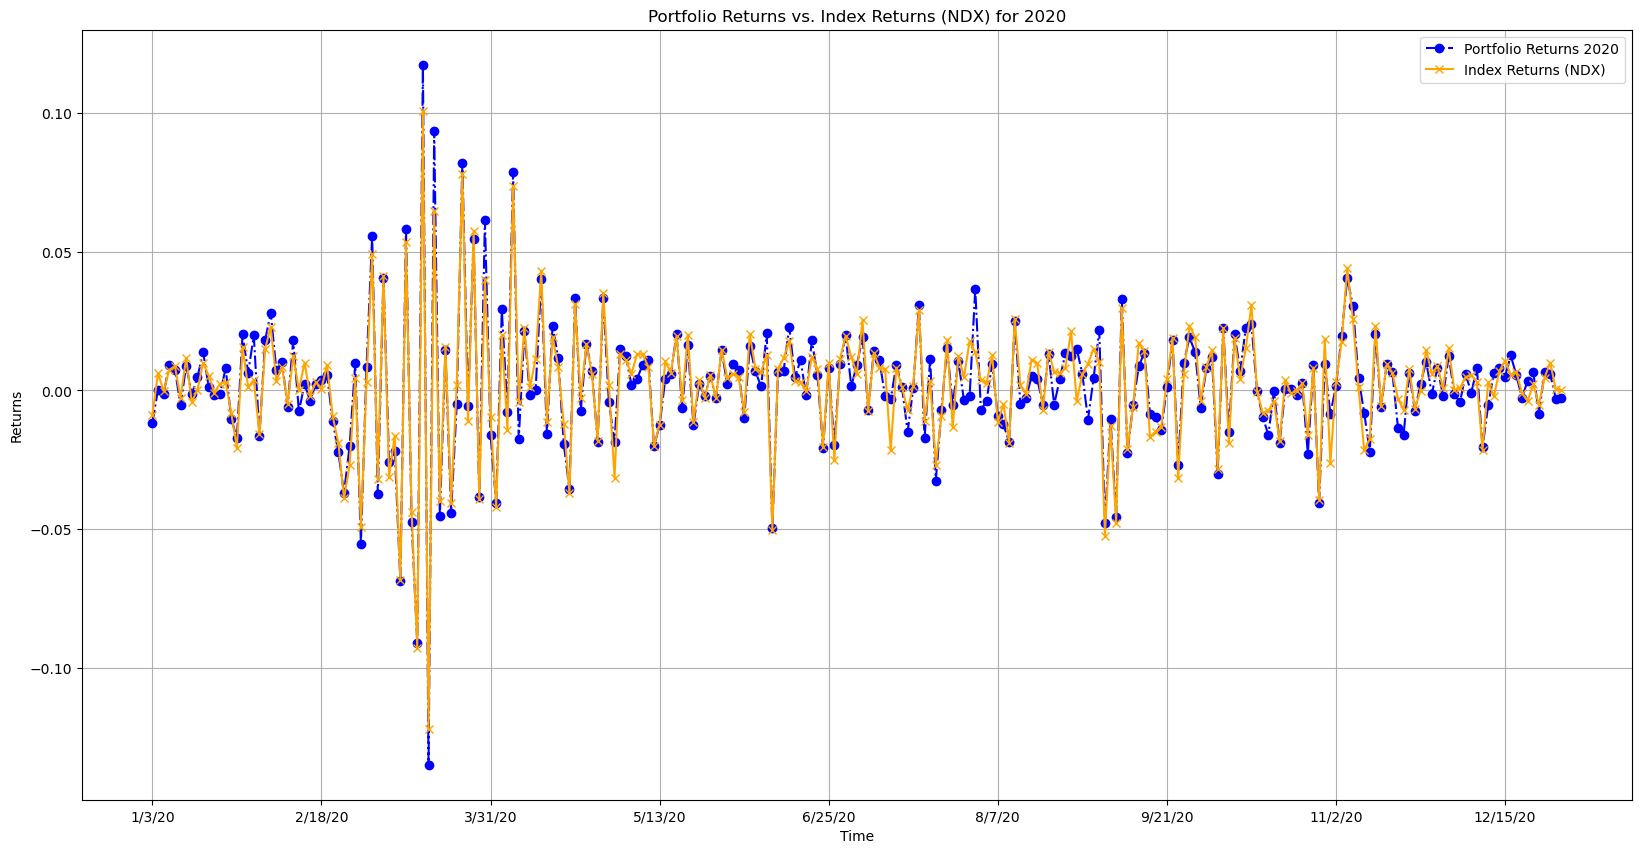

In [217]:
# Plotting the trends
plt.figure(figsize=(20, 10))
plt.plot(portfolio_returns_2020.index, portfolio_returns_2020['Portfolio_Return'], label='Portfolio Returns 2020', linestyle='-.', marker='o',color = 'blue')
plt.plot(ret_2.iloc[:, 0].index, ret_2.iloc[:, 0], label='Index Returns (NDX)', linestyle='-', marker='x',color = 'orange')

# Customize the plot
plt.title('Portfolio Returns vs. Index Returns (NDX) for 2020')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.legend()
plt.grid(True)

# Reduce the number of x-axis ticks (dates)
n = 30  # Adjust this value to change the frequency of displayed dates
plt.xticks(portfolio_returns_2020.index[::n])

# Show the plot
plt.show()

<div style="background-color: #f0f8ff; padding: 10px;">
   <font color="black" face="verdana" size="3">
   
### 3 ###
Redo step (2) with m = 10, 20, …, 90, 100 (obviously when m=100 you don’t need to solve for which stocks to include, because they’re all included). Analyze the performance of the portfolio for each value of m. How does the performance change? Is there some value of m, where there are diminishing returns of including more stocks in the portfolio? You can also look at the in-sample performance. That is, evaluate the performance in 2019 using 2019 portfolio construction and 2019 data. How is performance in 2019 different than performance in 2020? Why is it different? Be sure to write your code so that if there are more or fewer than 100 stocks in the csv file it stops at the right place.

</font>
</div>


In [218]:
i = 1
for m in m_list:
    selected_stocks = select_stocks(number_of_stocks,p,m)
    new_row_df = pd.DataFrame([selected_stocks], columns=column_names[2:])

    # Concatenate the original DataFrame and the new row DataFrame
    selected_df = pd.concat([selected_df, new_row_df], ignore_index=True)
    selected_df.at[len(selected_df)-1, 'M'] = m


    #Weight Calcuation
    weights_calculated_m, weights_calculated = weight_calculation(selected_stocks, ret,number_of_stocks, number_of_time_periods, m)

    new_row_df = pd.DataFrame([weights_calculated_m], columns=column_names[2:])

    # Concatenate the original DataFrame and the new row DataFrame
    weights_df = pd.concat([weights_df, new_row_df], ignore_index=True)
    weights_df.at[len(selected_df)-1, 'M'] = m

    values = index_return_calculation(weights_df.iloc[i,1:],ret_2,number_of_time_periods_2020,number_of_stocks,m)
    returns_df = returns_df.assign(**values)
    i = i+1

    portfolio_returns_2020, tracking_error_2020 = calculate_portfolio_metrics(weights_calculated, ret_2)
    portfolio_returns_2019, tracking_error_2019 = calculate_portfolio_metrics(weights_calculated, ret)  # Calculate 2019 variance

    # Store the variance data for both 2020 and 2019
    variance_data.append({'M': m, 'Variance for 2020': tracking_error_2020, 'Variance for 2019': tracking_error_2019})

# Create a new DataFrame from the variance data
variance_df = pd.DataFrame(variance_data)



The 10 selected stocks are:
Stock 1: ATVI
Stock 2: ALGN
Stock 3: EXPE
Stock 4: KHC
Stock 5: LBTYK
Stock 6: MXIM
Stock 7: MSFT
Stock 8: ROST
Stock 9: VRTX
Stock 10: XEL


For 10 stocks
Weight of stock ATVI: 0.04420008162515515
Weight of stock ALGN: 0.02499587429403977
Weight of stock EXPE: 0.02150098184560955
Weight of stock KHC: 0.023389314412142398
Weight of stock LBTYK: 0.03783494391598981
Weight of stock MXIM: 0.15698580809468035
Weight of stock MSFT: 0.4910305234120523
Weight of stock ROST: 0.0911518044588584
Weight of stock VRTX: 0.046216031808782046
Weight of stock XEL: 0.06269463613269025


The 20 selected stocks are:
Stock 1: ATVI
Stock 2: ALGN
Stock 3: GOOGL
Stock 4: ANSS
Stock 5: ADP
Stock 6: BIIB
Stock 7: CHTR
Stock 8: DLTR
Stock 9: EXPE
Stock 10: JD
Stock 11: KHC
Stock 12: LBTYK
Stock 13: MXIM
Stock 14: MSFT
Stock 15: MRNA
Stock 16: PCAR
Stock 17: PDD
Stock 18: ULTA
Stock 19: VRTX
Stock 20: XEL


For 20 stocks
Weight of stock ATVI: 0.017568251619137058
Weight of stock ALGN:

For 60 stocks
Weight of stock ADBE: 0.050551684988154634
Weight of stock AMD: 0.016880429624207775
Weight of stock ALXN: 0.00024066857743182955
Weight of stock ALGN: 0.00887560111283079
Weight of stock GOOGL: 0.15154006425896277
Weight of stock AMGN: 0.012462193877036488
Weight of stock AMAT: 0.03576652352387628
Weight of stock ADP: 0.02022624681736534
Weight of stock BIDU: 0.015861097255277443
Weight of stock BIIB: 0.005348589468692204
Weight of stock BKNG: 0.026145199058824883
Weight of stock CDW: 0.022682195839466186
Weight of stock CERN: 0.0044985128891060575
Weight of stock CHTR: 0.010802020652578712
Weight of stock CSCO: 0.047812973150474725
Weight of stock CTSH: 0.03406865418082996
Weight of stock CMCSA: 0.07348629469386837
Weight of stock COST: 0.015738121787414752
Weight of stock DOCU: 0.001820371981160253
Weight of stock DLTR: 0.006027976397112823
Weight of stock EBAY: 0.045306004847954766
Weight of stock EA: 0.008229037774514258
Weight of stock IDXX: 0.017327726327459245
Wei

The 90 selected stocks are:
Stock 1: ATVI
Stock 2: ADBE
Stock 3: AMD
Stock 4: ALXN
Stock 5: ALGN
Stock 6: GOOG
Stock 7: AMZN
Stock 8: AMGN
Stock 9: ANSS
Stock 10: AAPL
Stock 11: AMAT
Stock 12: ASML
Stock 13: ADSK
Stock 14: ADP
Stock 15: BIDU
Stock 16: BIIB
Stock 17: BMRN
Stock 18: BKNG
Stock 19: AVGO
Stock 20: CDW
Stock 21: CERN
Stock 22: CHTR
Stock 23: CHKP
Stock 24: CTAS
Stock 25: CSCO
Stock 26: CTXS
Stock 27: CTSH
Stock 28: CMCSA
Stock 29: CPRT
Stock 30: COST
Stock 31: CSX
Stock 32: DXCM
Stock 33: DOCU
Stock 34: DLTR
Stock 35: EBAY
Stock 36: EA
Stock 37: EXC
Stock 38: EXPE
Stock 39: FB
Stock 40: FAST
Stock 41: FISV
Stock 42: GILD
Stock 43: IDXX
Stock 44: ILMN
Stock 45: INCY
Stock 46: INTC
Stock 47: INTU
Stock 48: ISRG
Stock 49: JD
Stock 50: KHC
Stock 51: LBTYA
Stock 52: LULU
Stock 53: MAR
Stock 54: MELI
Stock 55: MCHP
Stock 56: MU
Stock 57: MSFT
Stock 58: MRNA
Stock 59: MDLZ
Stock 60: MNST
Stock 61: NTES
Stock 62: NFLX
Stock 63: NVDA
Stock 64: ORLY
Stock 65: PCAR
Stock 66: PAYX
Stoc

In [219]:
selected_df

,M,ATVI,ADBE,AMD,ALXN,ALGN,GOOGL,GOOG,AMZN,AMGN,...,TCOM,ULTA,VRSN,VRSK,VRTX,WBA,WDAY,WDC,XEL,XLNX
0,5,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,1.0,-0.0,-0.0,-0.0,1.0,-0.0
1,10,1.0,0.0,0.0,0.0,1.0,0.0,-0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,20,1.0,0.0,-0.0,-0.0,1.0,1.0,-0.0,-0.0,-0.0,...,-0.0,1.0,-0.0,-0.0,1.0,-0.0,-0.0,-0.0,1.0,-0.0
3,30,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,-0.0,1.0,-0.0,-0.0,1.0,0.0,-0.0,-0.0,1.0,-0.0
4,40,1.0,1.0,-0.0,0.0,1.0,1.0,0.0,0.0,1.0,...,-0.0,1.0,-0.0,-0.0,1.0,1.0,-0.0,-0.0,1.0,-0.0
5,50,1.0,1.0,0.0,1.0,1.0,1.0,0.0,-0.0,1.0,...,0.0,1.0,-0.0,-0.0,1.0,1.0,-0.0,-0.0,1.0,0.0
6,60,0.0,1.0,1.0,1.0,1.0,1.0,0.0,-0.0,1.0,...,1.0,1.0,-0.0,0.0,-0.0,1.0,-0.0,0.0,1.0,0.0
7,70,-0.0,0.0,1.0,1.0,1.0,1.0,0.0,-0.0,1.0,...,1.0,1.0,0.0,0.0,1.0,1.0,1.0,-0.0,1.0,-0.0
8,80,1.0,-0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,...,1.0,1.0,0.0,1.0,1.0,1.0,1.0,-0.0,1.0,1.0
9,90,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [220]:
weights_df

,M,ATVI,ADBE,AMD,ALXN,ALGN,GOOGL,GOOG,AMZN,AMGN,...,TCOM,ULTA,VRSN,VRSK,VRTX,WBA,WDAY,WDC,XEL,XLNX
0,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.07119,0.0,0.0,0.0,0.089208,0.0
1,10,0.0442,0.0,0.0,0.0,0.024996,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.046216,0.0,0.0,0.0,0.062695,0.0
2,20,0.017568,0.0,0.0,0.0,0.015085,0.183593,0.0,0.0,0.0,...,0.0,0.012464,0.0,0.0,0.036206,0.0,0.0,0.0,0.035462,0.0
3,30,0.020986,0.04838,0.0,0.0,0.0,0.151512,0.0,0.0,0.0,...,0.0,0.015619,0.0,0.0,0.02221,0.0,0.0,0.0,0.017055,0.0
4,40,0.025818,0.036219,0.0,0.0,0.005164,0.137528,0.0,0.0,0.048989,...,0.0,0.010036,0.0,0.0,0.000211,0.014549,0.0,0.0,0.0,0.0
5,50,0.019456,0.034341,0.0,0.007062,0.007861,0.129515,0.0,0.0,0.030491,...,0.0,0.006312,0.0,0.0,0.000693,0.00142,0.0,0.0,0.0,0.0
6,60,0.0,0.050552,0.01688,0.000241,0.008876,0.15154,0.0,0.0,0.012462,...,0.010468,0.009039,0.0,0.0,0.0,0.007366,0.0,0.0,0.011077,0.0
7,70,0.0,0.0,0.005603,0.0,0.008748,0.112409,0.0,0.0,0.024466,...,0.00789,0.005287,0.0,0.0,0.0,0.00101,0.010474,0.0,0.00199,0.0
8,80,0.008611,0.0,0.006453,0.001588,0.008199,0.096784,0.0,0.0,0.015357,...,0.001988,0.004657,0.0,0.008445,0.007505,0.00955,0.000251,0.0,0.0,0.016468
9,90,0.004072,0.0205,0.004434,0.004199,0.000135,0.0,0.084521,0.094883,0.01289,...,0.002052,0.003137,0.001713,0.006507,0.006538,0.008067,0.001154,0.001981,0.008391,0.007944


In [221]:
returns_df

,5,10,20,30,40,50,60,70,80,90,100
1/3/20,0.002878,0.001503,0.001057,0.001727,0.002286,0.001840,0.000638,0.000795,0.000274,0.000050,0.000027
1/6/20,0.005934,0.004308,0.001344,0.002161,0.001781,0.002362,0.003283,0.001426,0.000130,0.000286,0.000451
1/7/20,0.000955,0.000074,0.000011,0.002855,0.001544,0.001441,0.001530,0.002593,0.000536,0.000043,0.000384
1/8/20,0.001837,0.000090,0.000074,0.001585,0.001872,0.000628,0.001105,0.000118,0.000533,0.000659,0.000832
1/9/20,0.001130,0.000684,0.000663,0.001910,0.002166,0.001917,0.002511,0.001118,0.000741,0.000127,0.000245
...,...,...,...,...,...,...,...,...,...,...,...
12/24/20,0.002024,0.001449,0.001877,0.000636,0.000101,0.000132,0.001749,0.000999,0.000058,0.001055,0.000989
12/28/20,0.004141,0.001202,0.005822,0.002999,0.004991,0.004758,0.004435,0.001521,0.001862,0.002825,0.002945
12/29/20,0.003338,0.003472,0.001547,0.001705,0.003264,0.002644,0.001319,0.000256,0.000758,0.000157,0.000043
12/30/20,0.003032,0.001894,0.001664,0.001319,0.000573,0.000598,0.003850,0.000752,0.002310,0.003239,0.003191


In [223]:
# Calculate the difference between the two columns
variance_df['Difference'] = variance_df['Variance for 2020'] - variance_df['Variance for 2019']

# Display the updated DataFrame
variance_df

,M,Variance for 2020,Variance for 2019,Difference
0,5,1.112437,0.789178,0.323259
1,10,1.102404,0.701218,0.401187
2,20,0.855446,0.466268,0.389178
3,30,0.767367,0.409792,0.357574
4,40,0.767891,0.363281,0.404610
5,50,0.772100,0.332540,0.439560
6,60,1.164932,0.352056,0.812876
7,70,0.861893,0.233143,0.628751
8,80,0.537323,0.147683,0.389640
9,90,0.370506,0.053827,0.316678


<div style="background-color: #f0f8ff; padding: 10px;">
   <font color="black" face="verdana" size="3">
Plotting graphs for analysing the variances for 2019 and 2020

   </font>
</div>

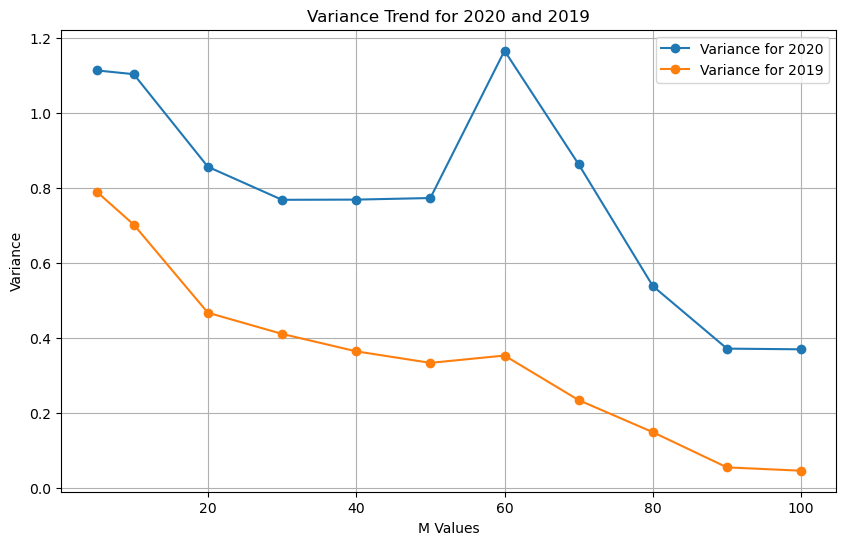

In [224]:
# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(variance_df['M'], variance_df['Variance for 2020'], label='Variance for 2020', marker='o')
plt.plot(variance_df['M'], variance_df['Variance for 2019'], label='Variance for 2019', marker='o')
plt.xlabel('M Values')
plt.ylabel('Variance')
plt.title('Variance Trend for 2020 and 2019')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

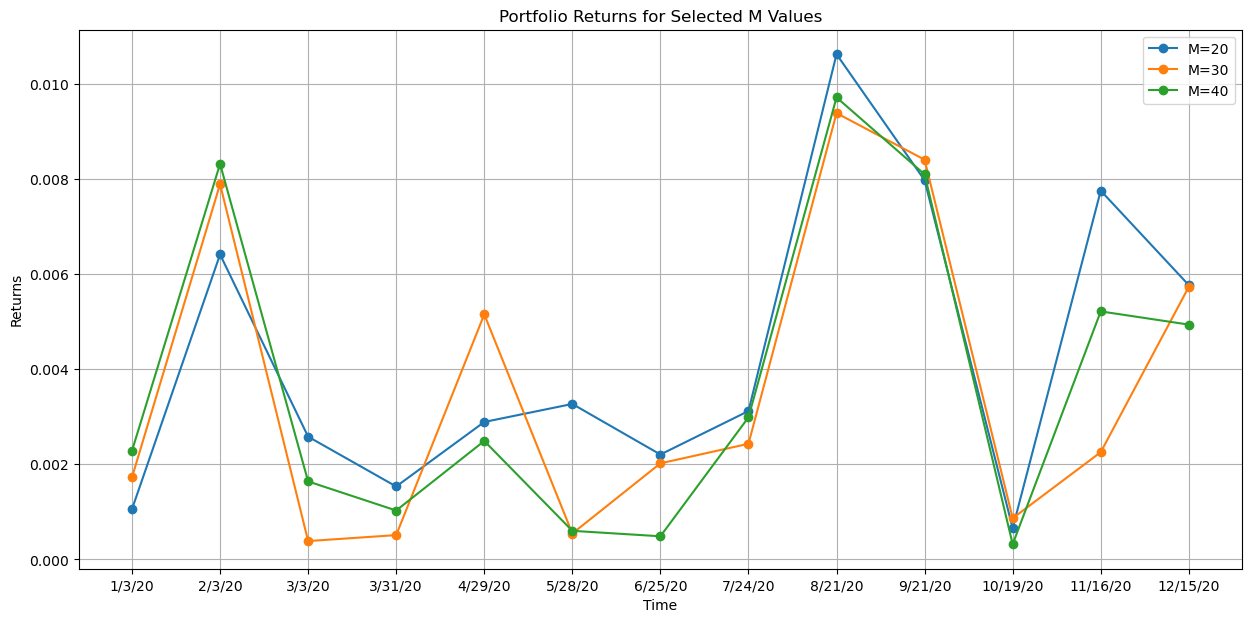

In [222]:
## Plotting a graph for a time period for three different m values
# Create a new figure for the plot
plt.figure(figsize=(15, 7))

# List of time values to consider (using every 5th time point)
time_values = returns_df.index[::20]

# Select the specific 'M' values to plot
m_values_to_plot = [20, 30, 40]

# Plot portfolio returns for selected 'M' values
for m_value in m_values_to_plot:
    returns_data = returns_df.iloc[:-1][str(m_value)]  # Exclude the last row and select the specific 'M' column
    plt.plot(time_values, returns_data[::20], label=f'M={m_value}', linestyle='-', marker='o')

# Customize the plot
plt.title('Portfolio Returns for Selected M Values')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.grid(True)
plt.legend(loc='upper right')

# Display the plot
plt.show()

<div style="background-color: #f0f8ff; padding: 10px;">
   <font color="black" face="verdana" size="3">
   
### 4 ###
Another way you could solve this problem is to completely ignore the stock selection IP and re-formulate the weight selection problem to be an MIP that constrains the number of non-zero weights to be an integer. To do this take the weight selection problem and replace m with n so that you are optimizing over ALL weights: 

$$ \underset{w}min \sum_{t=1}^T | q_t - \sum_{i=1}^n w_i r_{it}| $$

Now define some binary variables y1, y2, …, yn and add some constraints that force wi = 0 if yi = 0 using the ‘big M’ technique (What’s the smallest value of big M you could use?). You also need to add a constraint that the sum of y’s is equal to m (m and M are different things here…). It turns out that this is a VERY hard problem for gurobi to solve. After 24 hours running on my desktop gurobi didn’t find a solution! We can force gurobi to quit looking for a solution after a specific amount of time by setting the TimeLimit value, in units of seconds, in the params list (the place where we tell gurobi to shut up). Redo parts 2 and 3 with this new method to find weights. For each value of m, limit gurobi to work for 1 hour. Which method works better on the 2020 data, the original method or this new method? Note that your code will need to run for up to 10 hours to create your final output. I would suggest that you plan ahead and set this to run overnight. You can set your Python file to save your results for this part to a csv file, and then you can also have it check to see if that csv file exists, if it exists grab those results without spending the 10 hours, and if it doesn’t then re-solve the problem. That way you only have to do the big solution once and you can still work on the formatting of your Python file. In your Python file create a clearly obvious variable at the top, that is equal to 3600, that you reference to limit gurobi’s time. This way when we grade your solutions, we can set it to something smaller to make sure your code works without having to wait 10 hours for everyone’s code to run.

</font>
</div>


#### Setting the MIP model and finding weights for each of the m values

In [173]:
# Creating datasets to be used
df_2019_index = df_2019_returns.iloc[:,0]
df_2020_index = df_2020_returns.iloc[:,0]

df_2019_noindex = df_2019_returns.iloc[:,1:]
df_2020_noindex = df_2020_returns.iloc[:,1:]

In [172]:
# Defining some variables
stop_time = 3600

M = 1 #Smallest big M could be >1 because weights cannot be more than 1
total = df_2019_noindex.shape[0]

rt_2019 = df_2019_noindex.values
index_rt_2019 = df_2019_index.values

rt_2020 = df_2020_noindex.values
index_rt_2020 = df_2020_index.values

In [171]:
results = pd.DataFrame(columns=['m', 'selected_stocks', 'weights', 'error_of_2019','error_of_2020'])
m_list = [5] + [i for i in range(10, number_of_stocks + 1, 10)] # Start with m = 5
  
for m in m_list:
    
    #Define Model
    mod = gp.Model()
    
    # Define Variables: X-Weights, O - Error,Y - Chosen Stock or Not
    X = mod.addMVar(number_of_stocks,vtype='C',lb=0)
    O = mod.addMVar(total,vtype='C')
    Y = mod.addMVar(number_of_stocks,vtype='B')
    
    # Setting Objective
    mod.setObjective(gp.quicksum(O[i] for i in range(total)))

    # Setting Constraints
    constrweight = mod.addConstr(gp.quicksum(X[i] for i in range(number_of_stocks)) == 1)
    constrabs1 = mod.addConstrs((O[i] >= (index_rt_2019[i] - gp.quicksum(X[j]*rt_2019[i][j] for j in range(number_of_stocks)))) for i in range(total))
    constrabs2 = mod.addConstrs((O[i] >= -1*(index_rt_2019[i] - gp.quicksum(X[j]*rt_2019[i][j] for j in range(number_of_stocks)))) for i in range(total))
    constrbigM = mod.addConstrs((X[i] <= M*Y[i]) for i in range(number_of_stocks))
    constrstocks = mod.addConstr(gp.quicksum(Y[i] for i in range(number_of_stocks)) == m)

    mod.Params.OutputFlag = 0 # tell gurobi to shut up!!
    mod.setParam('TimeLimit', stop_time) # Stopping gurobi after 1 hour
    mod.optimize()
    
    
    weights = [X[i].X for i in range(number_of_stocks) if Y[i].X == 1]
    err_2019 = mod.ObjVal
    selected_stocks = [p.columns[j] for j in range(number_of_stocks) if Y[j].X == 1]
    
    # Find error for year 2020
    rt_2020 = df_2020_noindex
    index_rt_2020 = df_2020_index
    T = len(rt_2020)
   
    total_error = 0
    for t in range(T):
        total_error += abs(index_rt_2020.iloc[t] - sum(X[i].X * rt_2020.iloc[t,i] for i in range(number_of_stocks)))
        
    err_2020 = total_error
    
    #Append it to a dataframe
    new_addition = {'m': m, 'selected_stocks': selected_stocks, 'weights': weights, 'error_of_2019': err_2019, 'error_of_2020': err_2020}
    results.loc[len(results)] = new_addition

results.to_csv('result.csv', index=False)

#### Using the previously found weight values and calculating the variance for both year

In [183]:
import os

if os.path.exists('result.csv'):
    fund = pd.read_csv('result.csv', index_col = 0)
else:
    print(f"The file does not exist.")

In [184]:
fund

,selected_stocks,weights,error_of_2019,error_of_2020
m,,,,
5,"['AMZN', 'ADI', 'AAPL', 'MSFT', 'MDLZ']","[0.25012259799984393, 0.11375807105291455, 0.1...",0.499259,0.777362
10,"['GOOGL', 'AMZN', 'AMGN', 'AAPL', 'FB', 'INTC'...","[0.09350273277588875, 0.12580811985444165, 0.0...",0.290137,0.753372
20,"['ADBE', 'GOOGL', 'AMZN', 'AMGN', 'AAPL', 'ADP...","[0.03965063582581233, 0.08673323276085017, 0.0...",0.164639,0.579404
30,"['ADBE', 'AMD', 'ALXN', 'GOOG', 'AMZN', 'AMGN'...","[0.039541427154617, 0.008936426123727343, 0.00...",0.114082,0.505220
40,"['ADBE', 'AMD', 'GOOGL', 'AMZN', 'AMGN', 'AAPL...","[0.02545418559181543, 0.004913584548981473, 0....",0.082215,0.435368
50,"['ATVI', 'ADBE', 'AMD', 'ALXN', 'GOOG', 'AMZN'...","[0.00689728021092901, 0.025821934861864602, 0....",0.065023,0.385733
60,"['ATVI', 'ADBE', 'AMD', 'GOOGL', 'AMZN', 'AMGN...","[0.0022107880863217982, 0.021939986989190974, ...",0.052651,0.361089
70,"['ATVI', 'ADBE', 'AMD', 'GOOGL', 'AMZN', 'AMGN...","[0.0028154831209198485, 0.018330258040311128, ...",0.047488,0.360502
80,"['ATVI', 'ADBE', 'AMD', 'ALXN', 'GOOGL', 'GOOG...","[0.003119274021157583, 0.01784450654012397, 0....",0.045227,0.370629


In [190]:
# Select the columns you want to keep
selected_columns = ['error_of_2019', 'error_of_2020']

# Create a new DataFrame with the selected columns
variance_table_MIP = fund[selected_columns].copy()

# Calculate the difference between 'error_of_2020' and 'error_of_2019'
variance_table_MIP['difference'] = variance_table_MIP['error_of_2020'] - variance_table_MIP['error_of_2019']

variance_table_MIP.rename(columns={'error_of_2020': 'Variance of 2020','error_of_2019': 'Variance of 2019'}, inplace=True)

In [191]:
variance_table_MIP

,Variance of 2019,Variance of 2020,difference
m,,,
5,0.499259,0.777362,0.278104
10,0.290137,0.753372,0.463235
20,0.164639,0.579404,0.414765
30,0.114082,0.505220,0.391139
40,0.082215,0.435368,0.353153
50,0.065023,0.385733,0.320710
60,0.052651,0.361089,0.308439
70,0.047488,0.360502,0.313015
80,0.045227,0.370629,0.325401


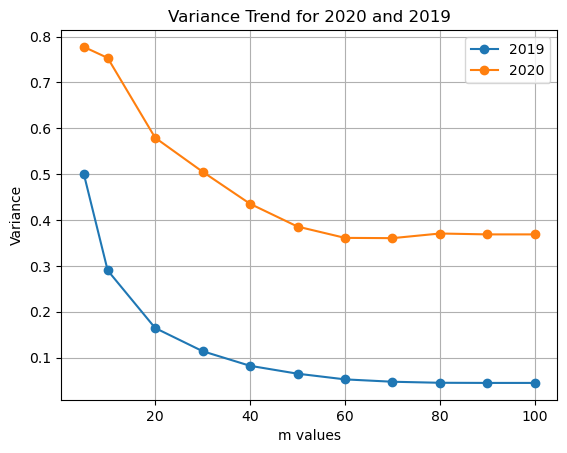

In [193]:
# Plotting the performance of portfolio in 2019 and 2020
plt.plot(variance_table_MIP['Variance of 2019'], label = '2019',marker='o')
plt.plot(variance_table_MIP['Variance of 2020'], label = '2020',marker='o')
plt.ylabel('Variance')
plt.xlabel('m values')
plt.title('Performance of PORTFOLIO in 2019 and 2020')
plt.title('Variance Trend for 2020 and 2019')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()